##Initial modelling to determine # of components

In [0]:
#Linear PCA

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Loading the dataset
try:
  dataset = pd.read_csv('drive/My Drive/processed.csv')
except:
  dataset = pd.read_csv('processed.csv')

# print(dataset)

X = dataset.iloc[:,2:].values #We are not using column 1. Also we slice it this way because we want X to be a matrix
y = dataset.iloc[:,1].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [0]:
# Import required libraries for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Normalizing the features
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

#Linear PCA
PCAObj = PCA(n_components=None, random_state=42)
X_train = PCAObj.fit_transform(X_train)
X_test = PCAObj.transform(X_test)



Number of components with 0.95 cumulative variance:  249


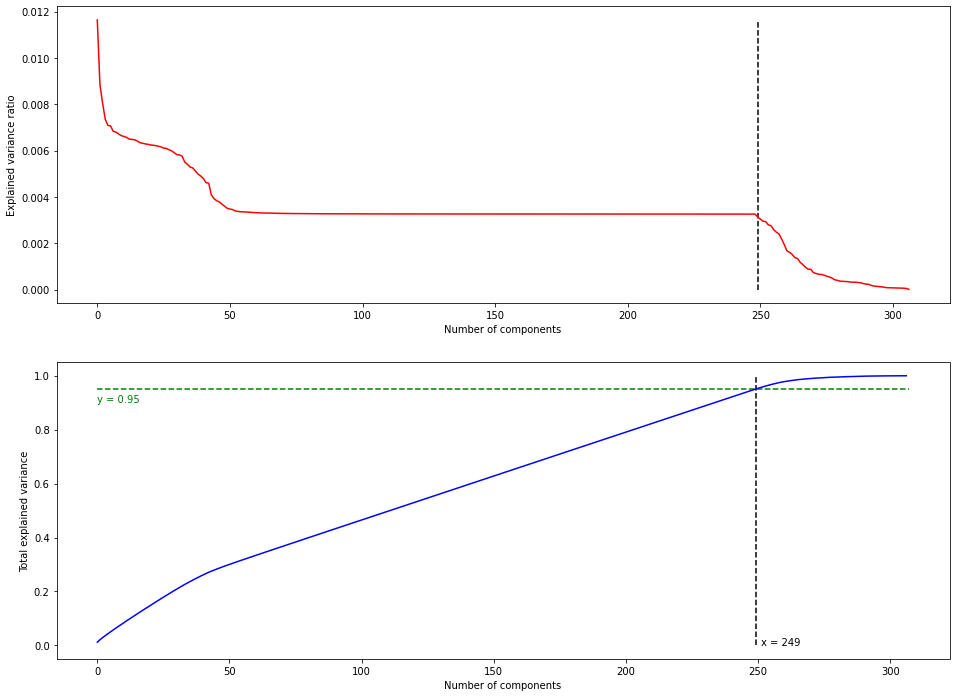

In [5]:
# Define cumulative explained variance ratio
total_variance = np.cumsum(PCAObj.explained_variance_ratio_)

# Show when total_variance is 0.95 using a plot
plt.figure(1, figsize=[16,12])
plot1 = plt.subplot(211)
plt.plot(PCAObj.explained_variance_ratio_, c='red')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')

plot2 = plt.subplot(212)
plt.plot(total_variance, c='blue')
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
# Look for where cumulative explained variance is 0.95
expl_95_index = np.where((total_variance > 0.949) & (total_variance < 0.951))[0][0]
print('Number of components with 0.95 cumulative variance: ', expl_95_index)
plt.hlines(0.95, 0, len(total_variance), linestyles='dashed', color='green')
plt.vlines(expl_95_index, 0, 1, linestyles='dashed')
plot1.vlines(expl_95_index, 0, np.max(PCAObj.explained_variance_ratio_), linestyles='dashed')
plt.text(0, 0.95-0.05, 'y = 0.95', color='green')
plt.text(expl_95_index+2, 0, 'x = '+str(expl_95_index))

plt.show()

# Clear variables except the index to "reset" the runtime

In [0]:
%reset_selective -f ^(?!expl_95_index).*$ 

## Run PCA with the # of components from above

In [0]:
#Linear PCA

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Loading the dataset
try:
  dataset = pd.read_csv('drive/My Drive/processed.csv')
except:
  dataset = pd.read_csv('processed.csv')

# print(dataset)

X = dataset.iloc[:,2:].values #We are not using column 1. Also we slice it this way because we want X to be a matrix
y = dataset.iloc[:,1].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [8]:
# Import required libraries for making a PCA pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline for predicting the target
RF_PCA_pipeline = Pipeline([
                    ('scale', StandardScaler()), 
                    ('PCA', PCA(n_components=expl_95_index, random_state=0)),
                    ('random_forest', RandomForestRegressor(random_state=0, n_estimators=10))
                     ], verbose=True)

grid_param = dict(random_forest__min_samples_leaf=[1,2,4,8,16,32,64])
searchObj = GridSearchCV(RF_PCA_pipeline, grid_param, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)
searchObj.fit(X_train, y_train)
y_pred = searchObj.predict(X_test)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 70.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 84.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 121.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 145.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 177.9min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 214.8min finished


[Pipeline] ............. (step 1 of 3) Processing scale, total=   2.4s
[Pipeline] ............... (step 2 of 3) Processing PCA, total=   6.9s
[Pipeline] ..... (step 3 of 3) Processing random_forest, total= 9.8min


In [9]:
# Evaluating the model
print(searchObj.best_params_)
print(mean_squared_error(y_test, y_pred))

print(y_test)
print(y_pred)
print(mean_squared_error(10**y_test, 10**y_pred))

{'random_forest__min_samples_leaf': 4}
0.03994580883392388
[3.11394335 4.0374265  3.91381385 ... 4.10720997 3.87506126 3.54406804]
[2.80846738 4.11299933 3.97394404 ... 4.13821421 3.98940529 3.62429493]
54557642.20787135


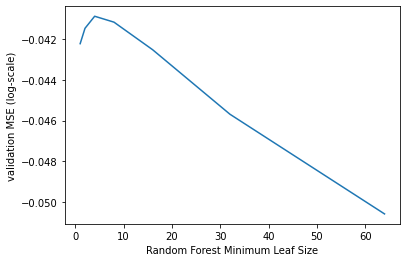

In [10]:
plt.plot(grid_param['random_forest__min_samples_leaf'], searchObj.cv_results_['mean_test_score'],
         )
plt.ylabel('validation MSE (log-scale)')
plt.xlabel('Random Forest Minimum Leaf Size')
plt.show()

In [11]:
#store results for later by printing
print(searchObj.cv_results_)

{'mean_fit_time': array([868.27028759, 829.42982767, 782.85304916, 735.92179899,
       682.93900478, 628.19381087, 546.5219111 ]), 'std_fit_time': array([ 8.36835357,  9.98268077,  4.82307847,  5.89689005,  6.51048334,
        4.79126662, 67.50454373]), 'mean_score_time': array([0.43250554, 0.3908941 , 0.4123816 , 0.40729544, 0.35730908,
       0.31658986, 0.29618168]), 'std_score_time': array([0.03526371, 0.03062551, 0.05884805, 0.08023027, 0.03718543,
       0.01229149, 0.04693929]), 'param_random_forest__min_samples_leaf': masked_array(data=[1, 2, 4, 8, 16, 32, 64],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'random_forest__min_samples_leaf': 1}, {'random_forest__min_samples_leaf': 2}, {'random_forest__min_samples_leaf': 4}, {'random_forest__min_samples_leaf': 8}, {'random_forest__min_samples_leaf': 16}, {'random_forest__min_samples_leaf': 32}, {'random_forest__min_samples_leaf': 64}], 'split0_t